# Classificação de Atividade Humana com PCA

Vamos trabalhar aqui com a mesma base utilizada na atividade anterior que está em **MOD27-Ex1-PCA**, caso queira conferir.

Para iniciar, iremos carregar os pacotes necessários e uma função que será utilizada durante a análise. 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


In [5]:
def metricas_avaliacao(model, pc_treino, y_train, pc_teste, y_test, cv=5):
    # Criando DataFrames para as componentes principais
    colunas = ['cp' + str(x + 1) for x in range(pc_treino.shape[1])]
    pc_train = pd.DataFrame(pc_treino, columns=colunas)
    pc_test = pd.DataFrame(pc_teste, columns=colunas)

    # Treinando o modelo com todos os dados de treino
    model.fit(pc_train, y_train)

    # Acurácia na base de treino
    train_accuracy = accuracy_score(y_train, model.predict(pc_train))

    # Acurácia na base de teste
    test_accuracy = accuracy_score(y_test, model.predict(pc_test))

    # Validação cruzada
    cv_scores = cross_val_score(model, pc_train, y_train, cv=cv)
    mean_cv_accuracy = cv_scores.mean()
    std_cv_accuracy = np.std(cv_scores)

    # Resultados com arredondamento
    results = {
        "Acurácia na base de treino": round(train_accuracy, 3),
        "Acurácia na base de teste": round(test_accuracy, 3),
        "Acurácia média da validação cruzada": round(mean_cv_accuracy, 3),
        "Desvio padrão da validação cruzada": round(std_cv_accuracy, 3)
    }

    return results

A função acima retorna as métricas de avaliação dos modelos que testaremos na finalização desta atividade. 

## Carregando os dados
Nessa atividade continuaremos investigando, como na atividade anterior a essa, o desempenho de uma árvore de classificação a partir da mudança no número de componentes. '**Qual o número de componentes ideal?**' é a pergunta que gostariamos de responder. Para além disso, surge aqui também mais uma dúvida que é a **padronização ou não dos dados**. Vamos lá descobrir então?

Mas antes de começar, vamos carregar a nossa base:

In [8]:
#carregando as bases
filename_features = "features.txt"
filename_labels = "activity_labels.txt"

filename_subtrain = "subject_train.txt"
filename_xtrain = "X_train.txt"
filename_ytrain = "y_train.txt"

filename_subtest = "subject_test.txt"
filename_xtest = "X_test.txt"
filename_ytest = "y_test.txt"

# Lendo o arquivo de características e convertendo para lista
features = pd.read_csv(filename_features, header=None, sep="#")
features_list = features.iloc[:, 0].tolist()

# Lendo os rótulos
labels = pd.read_csv(filename_labels, sep=r'\s+', header=None, names=['cod_label', 'label'])

# Lendo os dados de treino
subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, sep=r'\s+', header=None, names=features_list)
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

# Lendo os dados de teste
subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(filename_xtest, sep=r'\s+', header=None, names=features_list)
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

In [9]:
X_train

,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339


Agora que carregamos a base, vamos inciar a nossa exploração.

## PCA - Padronizar ou não padronizar os dados?

*Reflexão sobre a escala das variáveis:*

**Variáveis em métricas muito diferentes podem interferir na análise de componentes principais**. *Pense comigo*, se você tiver um df com 3 variáveis: renda, número de filhos e tempo de emprego, qual dessas variáveis assumirá maior variabilidade de valores? É claro que é renda, pois posso ter renda de 0 a 100000 por exemplo, enquanto número de filhos não vai ultrapassar 10 ou 12, então renda fica com uma variabilidade muito maior. 

Sabemos que variância é informação, assim, *as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis, fazendo com que todas as variáveis tenham a mesma importância na componente principal.*

Agora pense que queremos analisar notas de diferentes disciplinas, por todas se tratarem de notas, não há necessidade de padronização, uma vez que se uma disciplina tem notas semelhantes a todos os alunos, talvez ela não tenha tanto a dizer sobre esses alunos e as notas geralmente variam de 0 a 10. 

Então sabemos aqui que, nem sempre a padronização é a melhor escolha. _Mas e como saber se é a melhor escolha para a nossa base?_

De acordo com o arquivo README da nossa base, as nossas variáveis são normalizadas tendo valores pertencentes ao intervalo [-1, 1], logo, a padronização talvez não seja tão necessária, mas para uma maior assertividade, vamos testar dos dois modos, padronizados e não padronizados.

Iniciaremos testanto testando o número de componentes com as variáveis padronizadas. E para realizar essa análise, seguiremos alguns passos:

- Análise da variância explicada por componente
- Análise da variância explicada acumulada por componente
- Análise da variância percentual por componente
- Análise da variância percentual acumulada por componente
- Definir quantas componentes seriam escolhidas em cada caso para explicar 90% da variância.

Os passos acima também serão repetidos para o teste com as variáveis não padronizadas.

### PCA com variáveis padronizadas:

A padronização das variáveis tem como objetivo deixar a média igual a zero e o desvio padrão igual a 1.  Para entendermos melhor qual é o cálculo feito por traz disso utilizaremos a função abaixo, mas poderiamos utilizar o StandardScaler, uma classe do scikit-learn usada para padronizar as características (features) de um conjunto de dados. Como a fnção abaixo retorna o mesmo resultado e ainda permite visualizar os calculos, utilizaremos ela.

In [19]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()
X_test_pad= pd.DataFrame(X_test).apply(padroniza, axis=0)

CPU times: total: 812 ms
Wall time: 840 ms


Agora que nossos dados foram padronizados, iremos iniciar a análise dos componentes principais. A nossa análise terá como objetivo avaliar/observar o comportamento da variância explicada conforme aumenta-se o número de componentes, para assim termos uma ideia de quantos componentes são necessários para uma explicação razoável, com um bom custo benefício. *Por exemplo, não adianta eu selecionar 561 variáveis se as últimas 400 explicam apenas 10% da variância, nesse caso é mais intuítivo que eu fique com as 161 primeiras que me trazem 90% de explicação e um gasto muito menor de processamento aliado a menor risco de overfitting.*

Para observar esse comportamento da acurácia, criaremos 561 componentes, ou seja, número igual à quantidade de variáveis.

In [22]:
pca = PCA()

n_componentes = X_train_pad.shape[1]

princomp = pca.fit(X_train_pad)

componentes = princomp.transform(X_train_pad)

nomes_pca = ['CP'+str(x+1) for x in list(range(n_componentes))]

principalDf = pd.DataFrame(data = componentes
             , columns = nomes_pca)

In [23]:
principalDf.head()

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-16.137446,2.151878,3.144566,-0.272446,6.798476,-4.249105,2.936959,-4.905079,-0.775462,-3.627490,...,4.537003e-16,-2.575926e-16,-9.466559e-17,-4.039272e-16,9.575176e-17,-8.117011e-16,-8.590696e-17,5.519357e-17,-1.267579e-15,-1.768166e-15
1,-15.295154,1.387049,-0.682175,2.813486,4.265880,-2.055523,0.011204,-1.845860,0.492513,-0.180162,...,-1.032470e-16,4.642539e-17,-3.574192e-16,8.875533e-17,1.613372e-16,-5.576725e-16,1.659343e-16,2.891228e-16,-1.188047e-16,2.339449e-16
2,-15.135989,2.473183,-1.756521,3.717722,4.181273,-1.357425,0.072942,-1.388094,0.539717,-0.671666,...,-4.058540e-16,-3.909837e-17,2.459283e-17,1.709645e-16,-7.351727e-17,-5.093173e-18,-3.759208e-17,2.239583e-16,3.557545e-16,1.907801e-15
3,-15.349840,3.915414,-1.790201,2.567347,3.205621,-0.942880,0.530700,-1.832060,1.071444,-1.496887,...,-4.727045e-16,-1.378160e-16,3.239659e-16,-5.274942e-17,1.304136e-17,3.315946e-16,2.027701e-16,2.131070e-16,-1.416231e-16,3.908499e-16
4,-15.543756,4.598424,-2.188433,2.897381,3.079941,-1.061386,-1.048520,-0.816877,0.600022,1.118799,...,-1.367494e-16,-3.064380e-16,1.803215e-17,1.608973e-16,3.275985e-18,3.641850e-16,-4.304593e-17,-2.662668e-17,3.490523e-16,1.630247e-15


Aora que visualizamos o nosso Df resultante, vamos observar como se comporta a variância explicada acumulada dos componentes. 

In [25]:
princomp.explained_variance_ratio_.cumsum()

array([0.50781172, 0.57361853, 0.60168289, 0.62672242, 0.64560527,
       0.66284534, 0.67655545, 0.68854623, 0.69850482, 0.70815569,
       0.7167562 , 0.72475901, 0.73239898, 0.73885227, 0.74517551,
       0.75117273, 0.75704023, 0.76279431, 0.76847352, 0.77374648,
       0.77875011, 0.78363419, 0.78841625, 0.79310188, 0.79759477,
       0.80180504, 0.80598483, 0.81004053, 0.81392577, 0.81779595,
       0.82145554, 0.82500108, 0.8284805 , 0.83185237, 0.83514914,
       0.83843129, 0.84163659, 0.84459274, 0.84745996, 0.85031071,
       0.85299837, 0.85565457, 0.85828863, 0.86087714, 0.86336768,
       0.86583722, 0.86824402, 0.87060517, 0.87290796, 0.87518364,
       0.87738528, 0.87951995, 0.881597  , 0.88362196, 0.88561976,
       0.88759726, 0.88954   , 0.89144237, 0.89332302, 0.89518518,
       0.89699985, 0.89877366, 0.90053451, 0.90226735, 0.90397473,
       0.90566021, 0.90731636, 0.90894738, 0.91053175, 0.91210673,
       0.91363696, 0.91515901, 0.9166404 , 0.91810111, 0.91954

Observando a saída acima, podemos perceber que apenas 1 componente já nos traz a explicação de mais de 50% da variância desse df, com 3 componentes já é possível alcançar 60%. Perceba que conforme aumenta-se o número de componentes, diminui-se a explicação deles, uma vez que o primeiro explica 50% e é necessário o segundo e o terceiro para explicar mais 10%, então cada novo componente gerado, explica menos que o componente anterior. 

*Mas e quantos componentes são suficientes para uma boa explicação?*

Para tentar responder essa pergunta de forma mais intuítiva, vamos plotar 4 gráficos que tem como objetivo mostrar como se comporta a variância explicada em prol dos 561 componentes gerados. Esses gráficos deverão exibir: A variância explicada, a variância acumulada explicada e ambas em percentual, que torna esse entendimento mais didático e fácil.

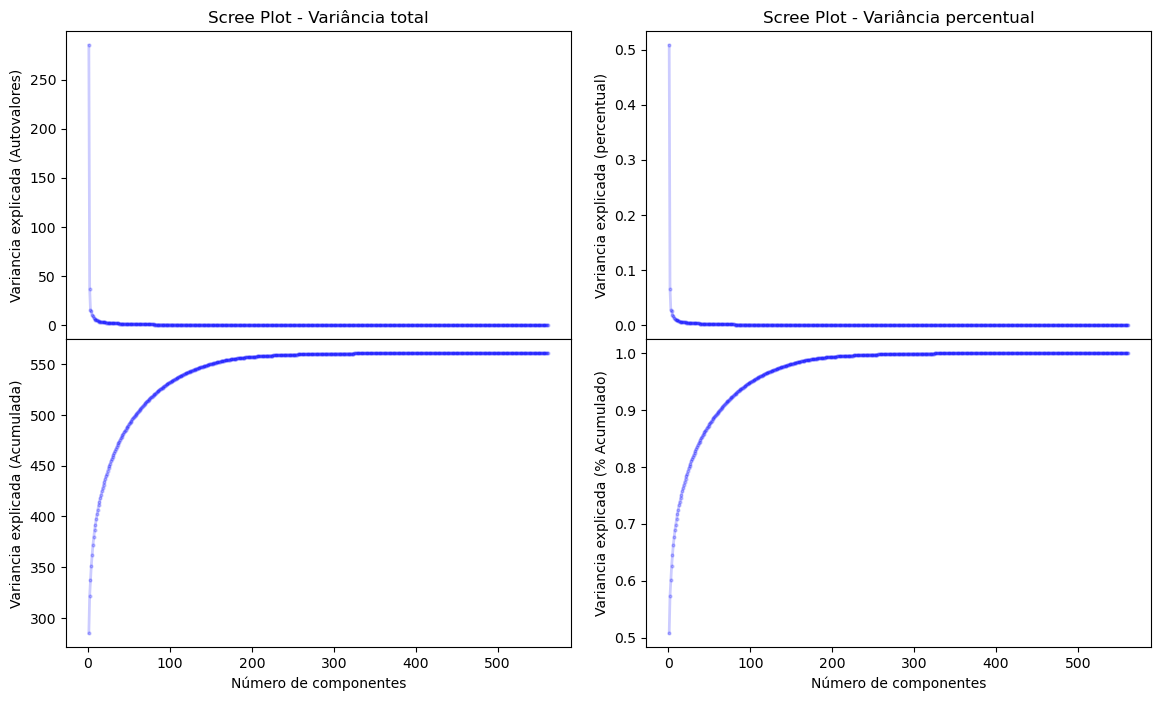

In [27]:
#GRÁFICOS VARIÂNCIA
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

ampli_y1 = princomp.explained_variance_[0]

num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')


ampli_y2 = princomp.explained_variance_ratio_[0]

ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

plt.show()

Podemos pensar assim, a variância total é a quantidade de componentes possíveis de gerar, nesse caso é 561 (nº de variáveis). Ao observarmos o primeiro gráfico, vemos que 1 componente é capaz de explicar mais de 250 da variância total dos componentes criados, enquanto que o gráfico à sua direita mostra que o primeiro componente explica mais de 50% da variância, logo, temos a mesma informação mas exibida em porcentagem, uma vez que 250/561 é mais de 50%. O mesmo ocorre na linha inferior.

**Enquanto que os gráficos da primeira linha diminuem, por conta de que um componente que vem primeiro sempre tem valor maior que o seu sucessor, os gráficos da linha debaixo, aumentam, uma vez que mostram as informações do gráfico de cima, acumuladas.** Perceba que o último gráfico mostra que a porcentagem da variância explicada de 1 componente é 50%, de 3 componentes é mais de 60%, exatamente como vimos na matriz gerada pelo código *princomp.explained_variance_ratio_.cumsum()*

*Mas ao olhar esses gráficos, como posso dizer qual é o número de componentes que traz o maior custo benefício?*

Bom, há alguns métodos para responder essa pergunta. Iremos testá-los a seguir:

### Critério 1 - autovalor > 1

No contexto do PCA, os autovalores estão associados a cada componente principal e indicam a importância desse componente em termos de variância. Quanto maior o autovalor, maior a variância explicada pelo componente principal correspondente. 

A ideia por trás do critério *"autovalor padronizado > 1"* é que componentes com autovalores maiores que 1 explicam mais variância do que qualquer variável original isolada (padronizada), e, portanto, devem ser mantidos. Se o autovalor de uma componente principal é menor que 1, ela explica menos variância do que qualquer variável original isoladamente, então não faz sentido manter essa componente no modelo, uma vez que sua contribuição para capturar a variabilidade dos dados é muito baixa

Para melhor identificarmos os autovalores maiores que 1, adicionaremos uma linha vertical e horizontal que nos aponta a 'quebra', ou seja, onde há a separação dos autovalores maiores e menores que 1.

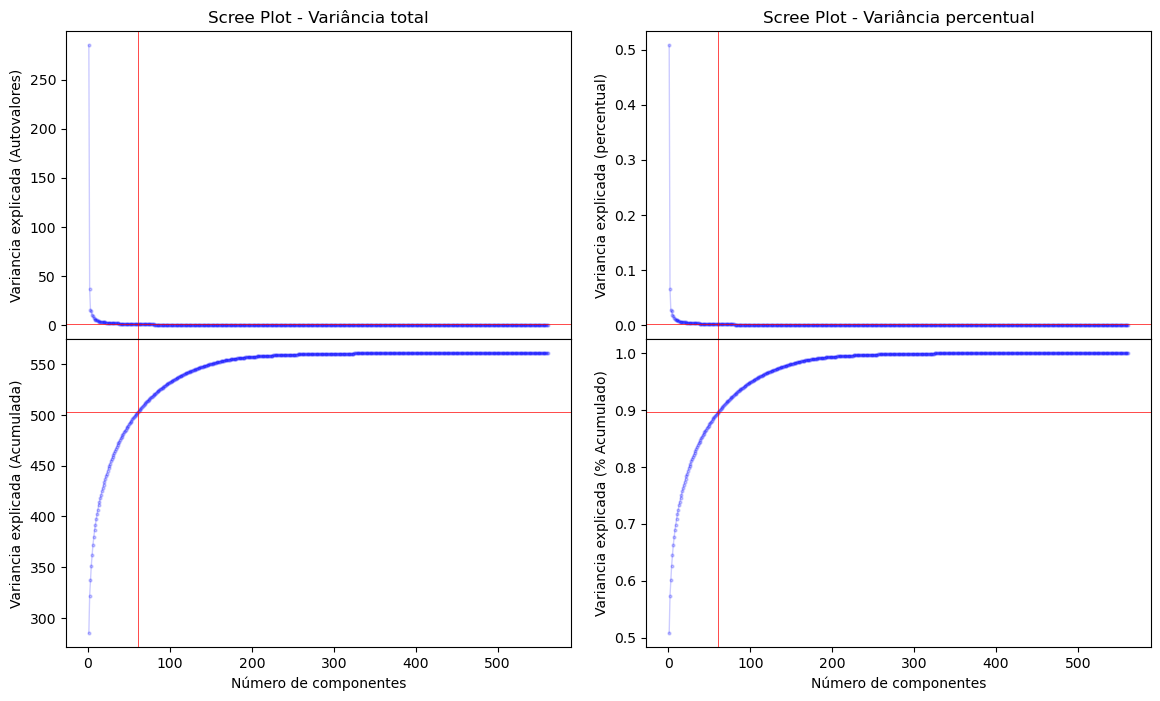

In [30]:
# Critério 1: autovalor padronizado > 1
ncomp_criterio1 = (princomp.explained_variance_ratio_>1/princomp.n_components_).sum()

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd_componentes
ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

# Gráfico da variância percentual por qtd_componentes
ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

# Gráfico da variância percentual acumulada por qtd_componentes
ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# Linhas verticais de referência
ax[0,0].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)


# linhas horizontais
ax[0,0].axhline(y = princomp.explained_variance_[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = princomp.explained_variance_.cumsum()[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = princomp.explained_variance_ratio_[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

Os gráficos, apontam que o número de componentes a ser usado é menor que 100. Mais espacificamente:

In [32]:
ncomp_criterio1 = (princomp.explained_variance_ratio_ > 1 / princomp.n_components_).sum()
ncomp_criterio1

61

**De acordo com o primeiro critério, devem ser utilizados 61 componentes.**

### Critério 2 - *screeplot* ou critério do cotovelo

Pudemos observar nos gráficos acima que começasse com um valor alto de variância explicada pelos componentes, mas como já dito, **à medida que mais componentes são adicionados, a quantidade de variância explicada começa a diminuir, e esse efeito é traduzido no gráfico através de uma curva que pode lembrar um cotovelo ou um joelho.**

O ponto onde a curva começa a achatar drasticamente é chamado de "ponto do cotovelo" e por isso, justamente essa quebra é mais intuítiva, precisamos realizar a observação e decidir, para ancorar essa decisão podemos utilizar aquela matriz novamente da variância explicada acumulada. Vejamos:


In [35]:
princomp.explained_variance_ratio_.cumsum()

array([0.50781172, 0.57361853, 0.60168289, 0.62672242, 0.64560527,
       0.66284534, 0.67655545, 0.68854623, 0.69850482, 0.70815569,
       0.7167562 , 0.72475901, 0.73239898, 0.73885227, 0.74517551,
       0.75117273, 0.75704023, 0.76279431, 0.76847352, 0.77374648,
       0.77875011, 0.78363419, 0.78841625, 0.79310188, 0.79759477,
       0.80180504, 0.80598483, 0.81004053, 0.81392577, 0.81779595,
       0.82145554, 0.82500108, 0.8284805 , 0.83185237, 0.83514914,
       0.83843129, 0.84163659, 0.84459274, 0.84745996, 0.85031071,
       0.85299837, 0.85565457, 0.85828863, 0.86087714, 0.86336768,
       0.86583722, 0.86824402, 0.87060517, 0.87290796, 0.87518364,
       0.87738528, 0.87951995, 0.881597  , 0.88362196, 0.88561976,
       0.88759726, 0.88954   , 0.89144237, 0.89332302, 0.89518518,
       0.89699985, 0.89877366, 0.90053451, 0.90226735, 0.90397473,
       0.90566021, 0.90731636, 0.90894738, 0.91053175, 0.91210673,
       0.91363696, 0.91515901, 0.9166404 , 0.91810111, 0.91954

Ao observar os valores acima podemos perceber que o aumento já é muito pequeno a partir do quarto componente, portanto, plotaremos o gráfico abaixo com essa quebra:

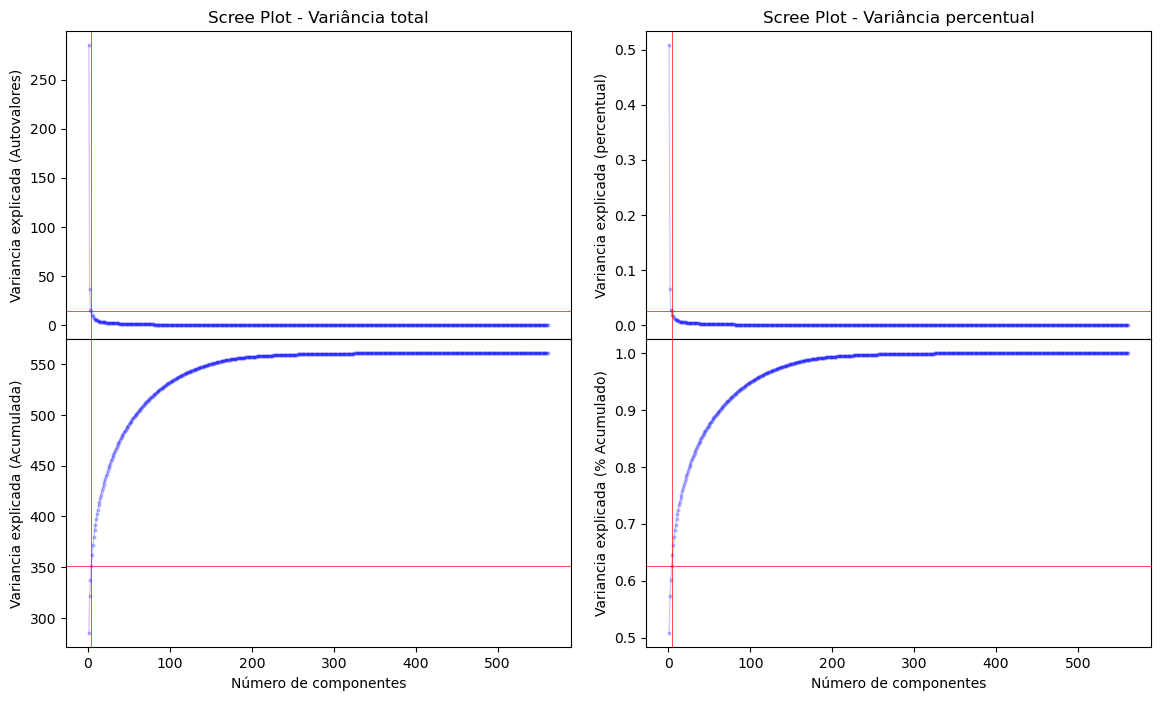

In [38]:
# Critério 2: Método do "cotovelo"
ncomp_criterio2 = 4

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# Número de componentes pelo critério 2
ax[0,0].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ax[0,0].axhline(y = princomp.explained_variance_[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = princomp.explained_variance_.cumsum()[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = princomp.explained_variance_ratio_[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

**De acordo com o segundo critério, intuítivo, devem ser utilizados 4 componentes.**

### Critéiro 3: Variância explicada > x

De acordo com esse critério, o usuário estabelece atarvés da acumulação da variância explicada um valor mínimo exigido, por exemplo 90% e ai o gráfico retornará para nós a quantidade de componentes necessária.

Vejamos:

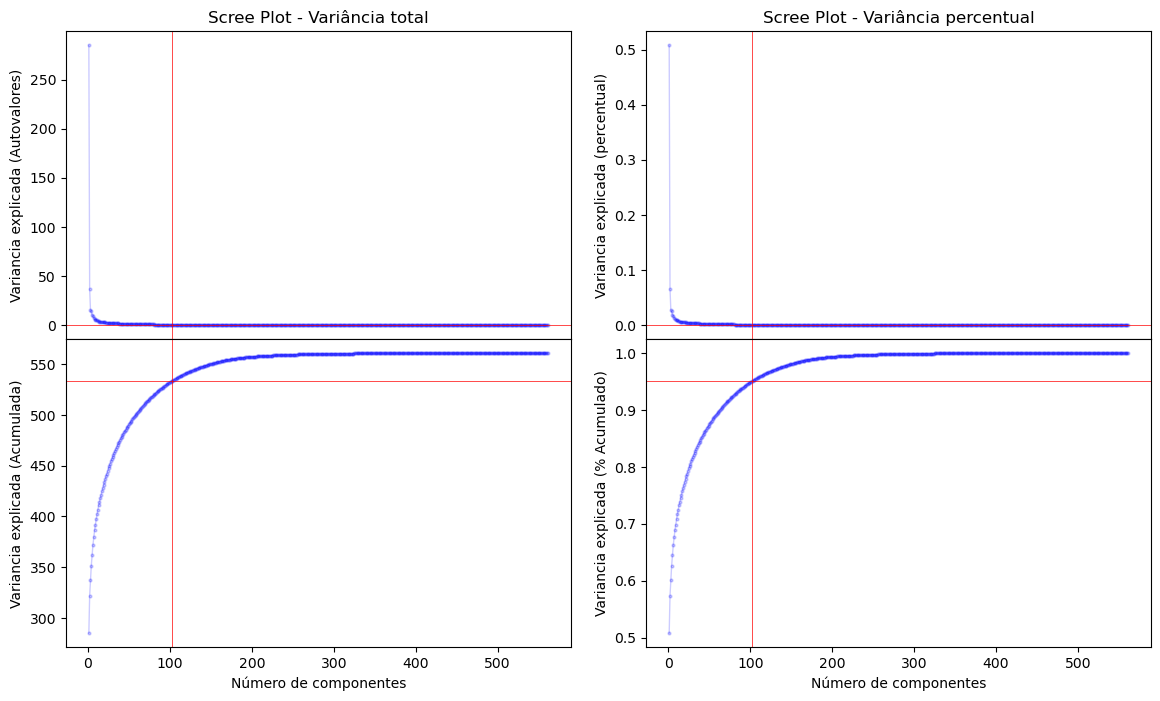

In [42]:
# Critério 3: % variância explicada

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério 3
varexplicada = .95
ncomp_criterio3 = (princomp.explained_variance_ratio_.cumsum()<varexplicada).sum()+1


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# linhas verticais de referência
ax[0,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ax[0,0].axhline(y = princomp.explained_variance_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = princomp.explained_variance_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = princomp.explained_variance_ratio_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

In [43]:
ncomp_criterio3 = (princomp.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1
ncomp_criterio3

102

**De acordo com o terceiro critério, devem ser utilizados 102 componentes.**

### Conclusões:
Agora, na hora de fazer a escolha da quantidade de componentes a serem utilizados, podemos construir uma árvore para cada um dos 3 critérios utilizados acima e ver qual nos retorna as melhores métricas.

*Mas, **vale ressaltar que** a depender do tamanho da base, da capacidade de processamento em que será executada, entre outras razões, fica a cargo do analista decidir qual é a melhor escolha, desde que vise o melhor desempenho possível.*

### Árvore - Critério 1 - Autovetor >1:

In [292]:
%%time
#CRITÉRIO1
#transformação do df para 61 componentes:
prcomp = PCA(n_components=61).fit(X_train_pad)

pc_treino = prcomp.transform(X_train_pad)
pc_teste  = prcomp.transform(X_test_pad)

CPU times: total: 3.48 s
Wall time: 785 ms


In [293]:
%%time
clf_c1 = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(pc_treino, y_train)

CPU times: total: 1.53 s
Wall time: 1.55 s


In [295]:
metricas_m1_pad= metricas_avaliacao(clf_c1, pc_treino, y_train, pc_teste, y_test)
metricas_m1_pad

{'Acurácia na base de treino': 0.896,
 'Acurácia na base de teste': 0.785,
 'Acurácia média da validação cruzada': 0.759,
 'Desvio padrão da validação cruzada': 0.02}

A acurácia na base de treino é um valor ótimo, mas, é necessário entender que o modelo aprende com a base de treino, logo, é mais comum que classifique essa base de forma mais assertiva. Já a acurácia na base de teste relata como o modelo treinado com as bases de treino, classificou esses dados sem nunca tê-los visto. 

A validação cruzada dividindo os dados em várias partes e treinando o modelo várias vezes com diferentes subconjuntos de dados. A acurácia média de 0.771 (77,1%) é a média das acurácias obtidas em diferentes iterações da validação cruzada. Essa métrica dá uma ideia mais robusta do desempenho do modelo, pois mostra como ele se comporta em diferentes divisões dos dados. A acurácia média próxima à da base de teste indica consistência.

O desvio padrão indica a variabilidade nas acurácias obtidas nas diferentes rodadas da validação cruzada. Um desvio padrão de 0.028 (2,8%) sugere que a acurácia do modelo é relativamente estável ao longo das diferentes divisões dos dados.

A **acurácia na base de treino** traz um resultado ótimo, 90%. No entanto, é importante lembrar que o modelo está aprendendo diretamente com essa base, então ele conhece bem esses dados e consegue classificá-los com maior precisão.  

Por outro lado, a **acurácia na base de teste** reflete como o modelo se comporta ao fazer previsões em dados que nunca viu antes. Essa métrica é fundamental, pois avalia a capacidade de generalização do modelo, ou seja, quão bem ele consegue lidar com dados novos, e aqui vimos que ele consegue classificar bem 78,6%.

A **validação cruzada** é uma técnica que divide os dados em diferentes subconjuntos, treinando e testando o modelo várias vezes em diferentes partes do conjunto de dados. A acurácia média de 0.771 (77,1%) é a média das acurácias obtidas nessas diferentes iterações. Essa métrica é uma forma mais robusta de avaliar o desempenho do modelo, já que ela mostra como ele se comporta em múltiplas divisões dos dados. Além disso, o fato de a acurácia média ser próxima à acurácia da base de teste sugere que o modelo tem um desempenho consistente e confiável.

O **desvio padrão da validação cruzada**, que é de 0.028 (2,8%), indica a variabilidade dos resultados obtidos nas diferentes rodadas da validação cruzada. Um desvio padrão baixo, como esse, sugere que o desempenho do modelo é estável.

Então, numa avaliação mais geral dessas métricas, temos uma classificação de aproximadamente 78% para novos dados.

### Árvore - Critério 2 - Cotovelo:

In [81]:
%%time
#CRITÉRIO2
#transformação do df para 4 componentes:
prcomp = PCA(n_components=4).fit(X_train_pad)

pc_treino = prcomp.transform(X_train_pad)
pc_teste  = prcomp.transform(X_test_pad)

CPU times: total: 906 ms
Wall time: 283 ms


In [82]:
%%time
clf_c2 = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(pc_treino, y_train)

CPU times: total: 125 ms
Wall time: 123 ms


In [84]:
metricas_avaliacao(clf_c2, pc_treino, y_train, pc_teste, y_test)

{'Acurácia na base de treino': 0.803,
 'Acurácia na base de teste': 0.755,
 'Acurácia média da validação cruzada': 0.712,
 'Desvio padrão da validação cruzada': 0.047}

Nesse modelo, utilizando apenas 4 componentes, a acurácia na base de treino traz um resultado mais próximo da base de teste e a base de teste nos mostra que ele classifica bem 75% da base de teste. 

Entretanto, a acurácia média da validação cruzada está um pouco mais distante desse valor e o desvio padrão também está maior que no primeiro método, apesar de ainda estar baixo, o modelo anterior ganha aí entre 3 e 7% a mais de assertividade na classificação. 

O tempo de processamento certamente é melhor, mas, como dito anteriormente, o analista deve avaliar se tem esse tempo e capacidade de processamento e optar pela melhor opção, caso ele tenha, acredito que 7% na melhora da acurácia média da validação cruzada é algo bem interessante de se tentar manter.

### Árvore - Critério 3 -  Porcentagem de Variância Explicada:

In [90]:
%%time
#CRITÉRIO3 
#transformação do df para 102 componentes:
prcomp = PCA(n_components=102).fit(X_train_pad)

pc_treino = prcomp.transform(X_train_pad)
pc_teste  = prcomp.transform(X_test_pad)

CPU times: total: 5.98 s
Wall time: 1.39 s


In [91]:
%%time
clf_c3 = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(pc_treino, y_train)

CPU times: total: 2.64 s
Wall time: 2.7 s


In [94]:
metricas_avaliacao(clf_c3, pc_treino, y_train, pc_teste, y_test)

{'Acurácia na base de treino': 0.901,
 'Acurácia na base de teste': 0.786,
 'Acurácia média da validação cruzada': 0.749,
 'Desvio padrão da validação cruzada': 0.035}

Esse último método nos retorna basicamente a mesma acurácia no treino que o primeiro método, a mesma acurácia na base de teste e uma acurácia menor na validação cruzada com um desvio padrão ainda maior. Logo, esse modelo é menos assertivo que o primeiro, apesar de ser treinado com mais componentes. 

**Definição da quantidade de componentes:** Ao observar os 3 modelos treinados, as melhores métricas foram alcançadas com o primeiro modelo, em que a quantidade de componentes são definidas através do critério _autovetor>1_. Apesar de não ser o que tem o melhor desempenho de tempo, também não é o pior, creio que aqui temos um caso de custo benefício. Portanto, a quantidade de componentes definidas, nesse caso, seria 61 componentes obtidos através do critério número 1. 

---

_Agora, vejamos se há alguma diferença ao repetir todo o processo acima sem padronizar as variáveis:_

## PCA com variáveis não padronizadas:

In [152]:
X_train.shape

(7352, 561)

In [160]:
pca = PCA()

n_componentes = X_train.shape[1]

princomp = pca.fit(X_train)

componentes = princomp.transform(X_train)

nomes_pca = ['CP'+str(x+1) for x in list(range(n_componentes))]

principalDf = pd.DataFrame(data = componentes
             , columns = nomes_pca)

In [161]:
principalDf

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-5.520280,-0.290278,-1.529929,1.333242,1.425089,-0.194708,0.577454,0.691490,-1.222865,-0.363414,...,4.474955e-17,3.514606e-17,-5.130338e-17,-1.413203e-17,3.730832e-17,1.402125e-15,1.167012e-16,-1.353012e-16,9.128229e-17,-5.140502e-17
1,-5.535350,-0.082530,-1.924804,0.671273,0.671260,0.735144,-0.616908,-0.771714,-0.615496,-0.895525,...,-2.341276e-17,3.635147e-17,-1.103512e-17,1.312242e-17,1.401263e-17,-4.763493e-16,-1.033289e-16,1.896282e-16,8.822486e-17,6.658243e-17
2,-5.474988,0.287387,-2.144642,0.531806,0.207824,-0.037772,0.057628,0.093917,-0.063147,-0.216898,...,5.934414e-17,7.018205e-17,-3.714451e-17,4.774844e-17,-3.528148e-17,9.956120e-16,-4.126886e-17,3.804663e-17,1.244327e-16,-2.545145e-17
3,-5.677232,0.897031,-2.018220,0.157125,0.759085,1.079547,-0.267805,-0.731391,0.281296,0.466269,...,5.293625e-17,9.098258e-17,-5.471059e-17,1.839269e-16,2.481196e-17,-3.442606e-16,1.705838e-16,8.474158e-17,-1.103491e-17,-1.128447e-16
4,-5.748749,1.162952,-2.139533,0.207823,0.473090,0.463035,-0.152227,-0.107509,0.289819,0.539206,...,5.055490e-17,6.549437e-17,-6.355817e-17,3.474575e-17,1.535673e-17,-5.790187e-16,6.387081e-17,-1.072592e-16,1.344100e-17,1.838171e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,6.253517,-2.636767,0.448229,1.476516,-0.767298,-0.268023,-1.348600,-0.463529,1.463389,0.210285,...,-3.208710e-17,-7.458363e-17,7.133947e-17,-3.000189e-17,7.774070e-17,7.150247e-16,-4.725013e-16,-4.282803e-17,-2.175803e-17,3.926713e-17
7348,5.782321,-2.437814,0.462731,1.711345,-0.825446,-0.403852,-1.257430,-0.319120,0.424317,-0.814650,...,5.754082e-18,-6.489421e-17,6.673170e-17,-1.406450e-16,8.601715e-17,1.455585e-15,6.961789e-17,-5.579962e-17,-6.381577e-17,4.768980e-17
7349,5.857505,-3.081843,0.671207,2.253646,-0.494577,0.391518,-1.000016,-0.162912,0.291533,1.248849,...,-1.313537e-16,-8.065199e-17,3.411403e-17,-5.889631e-19,-2.532506e-17,2.087780e-16,6.630588e-17,1.186807e-16,-1.306116e-17,5.090420e-17
7350,5.421095,-3.426430,0.671243,2.013981,-0.612601,0.443119,-1.445597,-0.112817,0.813037,1.681171,...,-5.860820e-17,-1.692162e-16,1.059462e-16,-6.715655e-17,2.062972e-17,2.458004e-15,-3.853523e-16,-1.933889e-17,3.827862e-17,-2.051764e-16


In [164]:
princomp.explained_variance_ratio_.cumsum()

array([0.6255444 , 0.67467463, 0.7158893 , 0.73463886, 0.75158746,
       0.76430816, 0.77607501, 0.78676474, 0.79645854, 0.80503872,
       0.81266174, 0.81938619, 0.82518039, 0.8307592 , 0.83574845,
       0.84049783, 0.84516983, 0.84948601, 0.85374316, 0.85784711,
       0.86178714, 0.86554023, 0.8690645 , 0.8724581 , 0.87577949,
       0.87897378, 0.88199157, 0.88490939, 0.88780509, 0.89062437,
       0.89339141, 0.89602536, 0.89857843, 0.90093709, 0.90324361,
       0.90548009, 0.90770957, 0.90981233, 0.91189626, 0.913944  ,
       0.91587257, 0.91776136, 0.91957316, 0.92136789, 0.92309117,
       0.92469319, 0.92626358, 0.92782986, 0.92935955, 0.93086307,
       0.93231424, 0.93372065, 0.9350889 , 0.93635748, 0.93760754,
       0.93880496, 0.93998616, 0.94113611, 0.94226693, 0.94336363,
       0.94444067, 0.94548967, 0.94652861, 0.94754335, 0.94853487,
       0.94950512, 0.95045922, 0.95137385, 0.95226151, 0.95313752,
       0.95399025, 0.95481929, 0.95564105, 0.95644739, 0.95722

Analisando a variância acumulada acima, podemos ver que aqui onde as variáveis não são padronizadas, com apenas 1 componente já temos 62% de explicação da variabilidade, enquanto que antes, era necessário pelo menos 4 componentes. Será que nesse caso, teremos um melhor desempenho sem padronizar as variáveis? 

É importante lembrar que na descrição desse banco de dados, está esclarecido que as variáveis já estão normalizadas, portanto _nesse caso a normalização dispensaria a padronização?_ Vejamos a seguir:

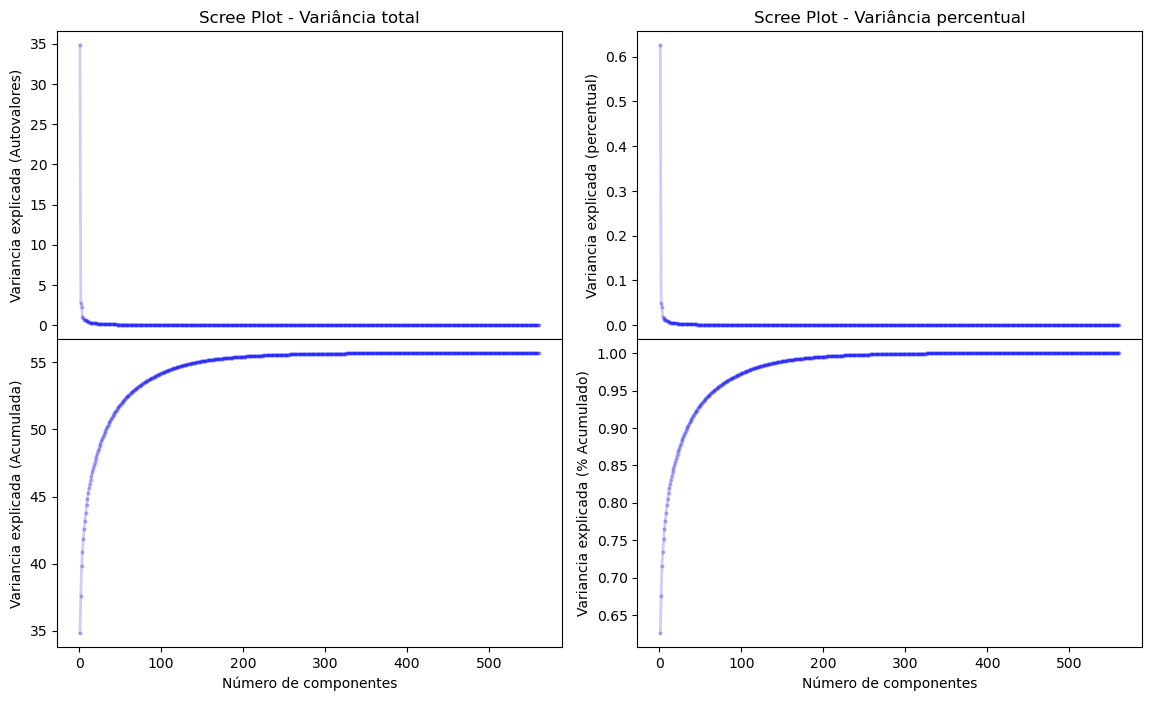

In [171]:
#GRÁFICOS DA VARIÂNCIA:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

ampli_y1 = princomp.explained_variance_[0]

num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')


ampli_y2 = princomp.explained_variance_ratio_[0]
# ax[1].set_ylim(-ampli_y2*.05, ampli_y2*1.1)

ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

plt.show()

Podemos observar que os gráficos acima tem um comportamento muito semelhante aos gráficos da variância padronizados, continuemos:

### Critério 1 - autovalor > 1

_A ideia por trás do critério "autovalor padronizado > 1" é que componentes com autovalores maiores que 1 explicam mais variância do que qualquer variável original isolada (padronizada), e, portanto, devem ser mantidos._

Para maior explicação, vide a primeira parte da análise, onde as variáveis foram padronizadas.

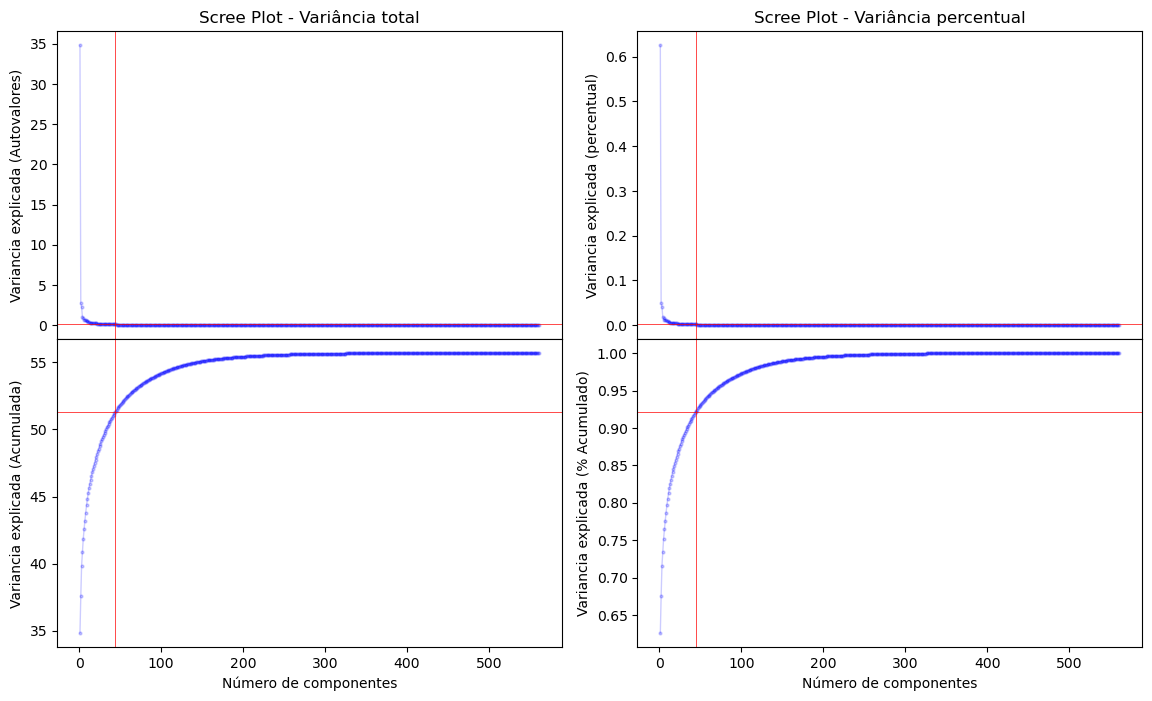

In [175]:
# Critério 1: autovalor padronizado > 1
ncomp_criterio1 = (princomp.explained_variance_ratio_>1/princomp.n_components_).sum()

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd_componentes
ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

# Gráfico da variância percentual por qtd_componentes
ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

# Gráfico da variância percentual acumulada por qtd_componentes
ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# Linhas verticais de referência
ax[0,0].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)


# linhas horizontais
ax[0,0].axhline(y = princomp.explained_variance_[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = princomp.explained_variance_.cumsum()[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = princomp.explained_variance_ratio_[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

In [178]:
ncomp_criterio1 = (princomp.explained_variance_ratio_ > 1 / princomp.n_components_).sum()
ncomp_criterio1

44

**De acordo com o primeiro critério, devem ser utilizados 44 componentes.**

### Critério 2 - *screeplot* ou critério do cotovelo

Gráfico do cotovelo (screeplot): Ao observar o gráfico da variância explicada por cada componente, buscamos um 'cotovelo' e ignoramos as variáveis que explicam muito pouco da variância total. Para auxiliar essa decisão, vejamos a variância explicada acumulada:

In [187]:
princomp.explained_variance_ratio_.cumsum()

array([0.6255444 , 0.67467463, 0.7158893 , 0.73463886, 0.75158746,
       0.76430816, 0.77607501, 0.78676474, 0.79645854, 0.80503872,
       0.81266174, 0.81938619, 0.82518039, 0.8307592 , 0.83574845,
       0.84049783, 0.84516983, 0.84948601, 0.85374316, 0.85784711,
       0.86178714, 0.86554023, 0.8690645 , 0.8724581 , 0.87577949,
       0.87897378, 0.88199157, 0.88490939, 0.88780509, 0.89062437,
       0.89339141, 0.89602536, 0.89857843, 0.90093709, 0.90324361,
       0.90548009, 0.90770957, 0.90981233, 0.91189626, 0.913944  ,
       0.91587257, 0.91776136, 0.91957316, 0.92136789, 0.92309117,
       0.92469319, 0.92626358, 0.92782986, 0.92935955, 0.93086307,
       0.93231424, 0.93372065, 0.9350889 , 0.93635748, 0.93760754,
       0.93880496, 0.93998616, 0.94113611, 0.94226693, 0.94336363,
       0.94444067, 0.94548967, 0.94652861, 0.94754335, 0.94853487,
       0.94950512, 0.95045922, 0.95137385, 0.95226151, 0.95313752,
       0.95399025, 0.95481929, 0.95564105, 0.95644739, 0.95722

Os cinco primeiros componentes revelam os maiores saltos, depois eles começam a ficar cada vez menores. Vamos portanto utilizar cinco.

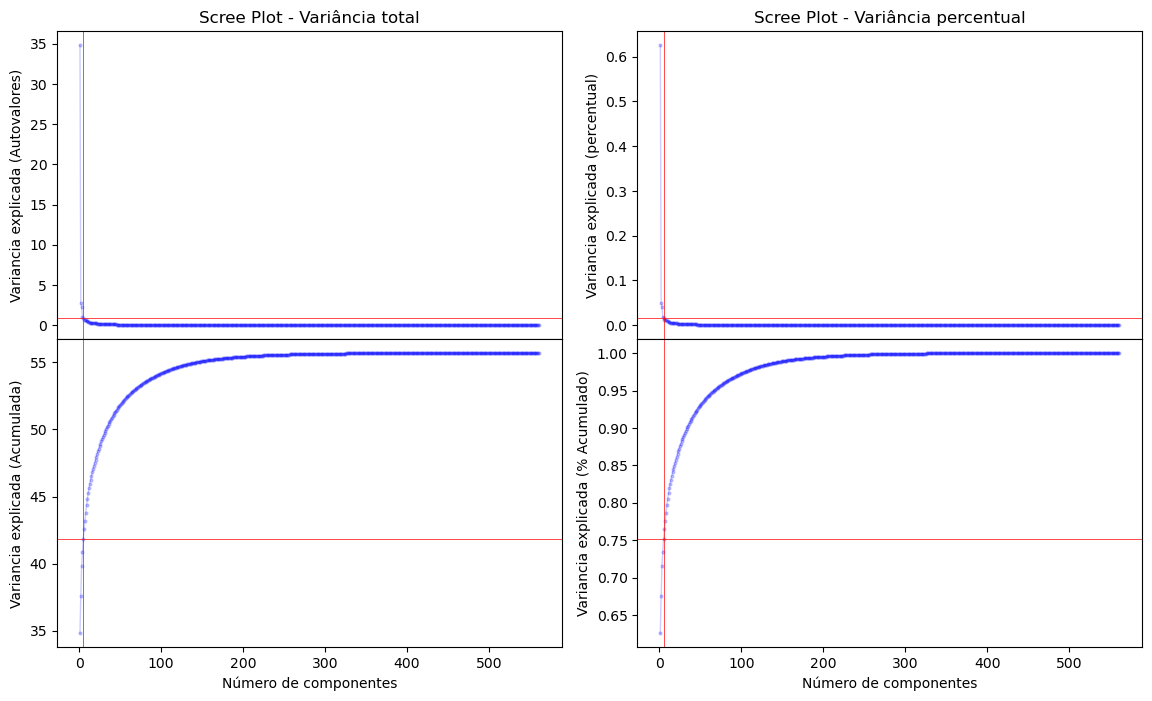

In [194]:
# Critério 2: Método do "cotovelo"
ncomp_criterio2 = 5

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# Número de componentes pelo critério 2
ax[0,0].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ax[0,0].axhline(y = princomp.explained_variance_[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = princomp.explained_variance_.cumsum()[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = princomp.explained_variance_ratio_[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

**De acordo com o segundo critério, devem ser utilizados 5 componentes.**

### Critéiro 3: Variância explicada > x

Variância explicada > x: Somando a variância explicada você pode estabelecer um valor mínimo exigido, por exemplo 90%, e selecionar o número de componentes que explica 90% da variância total.

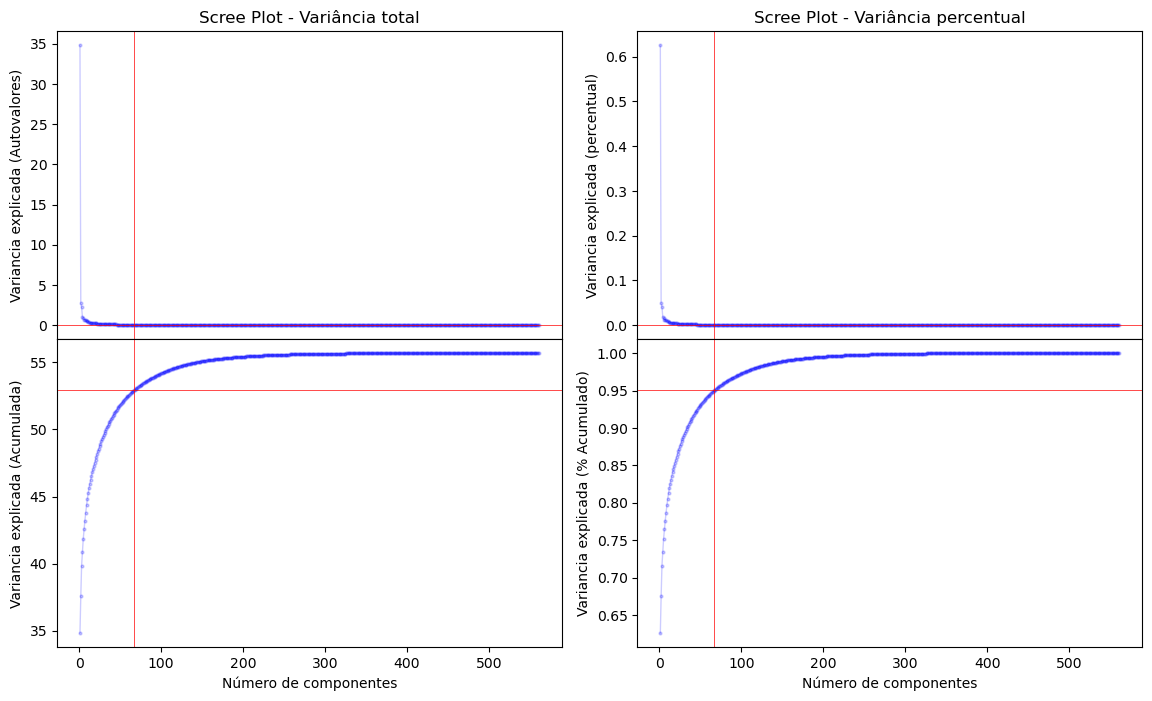

In [198]:
# Critério 3: % variância explicada

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério 3
varexplicada = .95
ncomp_criterio3 = (princomp.explained_variance_ratio_.cumsum()<varexplicada).sum()+1


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# linhas verticais de referência
ax[0,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ncomp_criterio2 = 50
ax[0,0].axhline(y = princomp.explained_variance_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = princomp.explained_variance_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = princomp.explained_variance_ratio_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

In [200]:
ncomp_criterio3 = (princomp.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1
ncomp_criterio3

67

**De acordo com o terceiro critério, devem ser utilizados 67 componentes, um número muito menor que o obtido ao padronizar as variáveis.**

Aqui encontramos para o primeiro e terceiro método, um número de componentes bastante inferior aos encontrados com os dados padronizados. _Mas e será que esses números nos retornarão um bom desempenho do modelo?_

Vamos criar e treinar os modelos e depois, ao final do treino dos 3 modelos, analisaremos e compararemos as acurácias destes.

### Árvore - Critério 1 - Autovetor >1:

In [260]:
%%time
#CRITÉRIO1
#transformação do df para 44 componentes:
prcomp = PCA(n_components=44).fit(X_train)

pc_treino1 = prcomp.transform(X_train)
pc_teste1  = prcomp.transform(X_test)

CPU times: total: 3.83 s
Wall time: 950 ms


In [261]:
%%time
clf_c1 = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(pc_treino1, y_train)

CPU times: total: 1.14 s
Wall time: 1.21 s


### Árvore - Critério 2 - Cotovelo:

In [266]:
%%time
#CRITÉRIO2
#transformação do df para 5 componentes:
prcomp = PCA(n_components=5).fit(X_train)

pc_treino2 = prcomp.transform(X_train)
pc_teste2  = prcomp.transform(X_test)

CPU times: total: 594 ms
Wall time: 265 ms


In [268]:
%%time
clf_c2 = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(pc_treino2, y_train)

CPU times: total: 109 ms
Wall time: 96.4 ms


### Árvore - Critério 3 -  Porcentagem de Variância Explicada:

In [272]:
%%time
#CRITÉRIO3
#transformação do df para 67 componentes:
prcomp = PCA(n_components=67).fit(X_train)

pc_treino3 = prcomp.transform(X_train)
pc_teste3  = prcomp.transform(X_test)

CPU times: total: 3.83 s
Wall time: 765 ms


In [274]:
%%time
clf_c3 = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(pc_treino3, y_train)

CPU times: total: 1.56 s
Wall time: 1.72 s


#### **Conclusão e definição da quantidade de componentes**:

Para facilitar essa análise, vamos exibir as métricas dos modelos acima, uma embaixo da outra:

In [264]:
#MODELO 1 - AUTOVETOR >1 : 44 COMPONENTES
metricas_avaliacao(clf_c1, pc_treino1, y_train, pc_teste1, y_test)

{'Acurácia na base de treino': 0.919,
 'Acurácia na base de teste': 0.825,
 'Acurácia média da validação cruzada': 0.785,
 'Desvio padrão da validação cruzada': 0.044}

In [270]:
#MODELO 2 - COTOVELO : 5 COMPONENTES
metricas_avaliacao(clf_c2, pc_treino2, y_train, pc_teste2, y_test)

{'Acurácia na base de treino': 0.846,
 'Acurácia na base de teste': 0.789,
 'Acurácia média da validação cruzada': 0.752,
 'Desvio padrão da validação cruzada': 0.048}

In [298]:
#MODELO 3 - PORCENTAGEM DE ACURÁCIA DEFINIDA : 67 COMPONENTES
metricas_m3_nao_pad= metricas_avaliacao(clf_c3, pc_treino3, y_train, pc_teste3, y_test)
metricas_m3_nao_pad

{'Acurácia na base de treino': 0.919,
 'Acurácia na base de teste': 0.83,
 'Acurácia média da validação cruzada': 0.784,
 'Desvio padrão da validação cruzada': 0.043}

#### **Definição da quantidade de componentes:**

**Base de treino:** Como é de se esperar, tivemos boas acurácias para todos os modelos na base de treino, sendo a mais baixa 0.846 do modelo com 5 componentes.

**Base de teste:** Os modelos com melhores acurácias foram 66 componentes, seguido e muito próximo de 44 componentes e por último 5 componentes. Entretanto, entre os três, o que teve menor diferença de acurácia com a base de treino foi o segundo, com 5 componentes.

**Validação cruzada:** A validação cruzada média é a mais robusta dessas métricas de avaliação, uma vez que divide os dados em diferentes subconjuntos, treinando e testando o modelo várias vezes em diferentes partes do conjunto de dados. Nessa métrica, o primeiro modelo com 44 componentes é o que se sai melhor, seguido pelo de 67 e por último, mas o que apresenta menor diferença com a acurácia na base de teste, o modelo com 5 componentes.

**Desvio Padrão:** Todos os desvios padrões da acurácia média tem valores muito parecidos e abaixo de 0.05, logo, consideraremos todos bons. Mas para efeito de uma escolha mais técnica, o menor pertence ao terceiro modelo, seguido do primeiro e por último do segundo.


_Aqui a escolha é um pouco acirrada mas o modelo 3 parece ser o melhor, uma vez que tem maior acurácia na base de teste (0.83), sua acurácia média na validação cruzada (0.784) é praticamente igual à do Modelo 1 (0.785) e tem o menor desvio padrão (0.043), sugerindo maior consistência._

**Logo, nossa escolha para a base não padronizada foram 67 componentes, utilizamos o terceiro critério.**

___

Mas e no final, qual base gerou mehor desempenho? Vamos comparar as métricas dos dados padronizados escolhidos e dos não padronizados escolhidos:

In [299]:
metricas_m1_pad

{'Acurácia na base de treino': 0.896,
 'Acurácia na base de teste': 0.785,
 'Acurácia média da validação cruzada': 0.759,
 'Desvio padrão da validação cruzada': 0.02}

In [302]:
metricas_m3_nao_pad

{'Acurácia na base de treino': 0.919,
 'Acurácia na base de teste': 0.83,
 'Acurácia média da validação cruzada': 0.784,
 'Desvio padrão da validação cruzada': 0.043}

Apesar do desvio padrão da base não padronizada ser maior, ele ainda não é um número considerado alto e sim aceitável. As demais métricas nos mostram que **o método não padronizado acabou se saindo melhor**. Vamos verificar se isso se repete para um número de componentes igual aos dois.

___

## Árvore com 10 Componentes Principais 

Serão feitas duas árvores de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Continuaremos a utilizar o ```ccp_alpha=0.001```.

### Dados padronizados - 10 Componentes:

In [373]:
%%time
#transformação do df para 10 componentes:
prcomp = PCA(n_components=10).fit(X_train_pad)

pc_treino = prcomp.transform(X_train_pad)
pc_teste  = prcomp.transform(X_test_pad)

CPU times: total: 672 ms
Wall time: 288 ms


In [375]:
%%time
clf10= DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(pc_treino, y_train)

CPU times: total: 234 ms
Wall time: 232 ms


In [377]:
metricas_avaliacao(clf10, pc_treino, y_train, pc_teste, y_test)

{'Acurácia na base de treino': 0.862,
 'Acurácia na base de teste': 0.782,
 'Acurácia média da validação cruzada': 0.75,
 'Desvio padrão da validação cruzada': 0.033}

### Dados não padronizados - 10 Componentes:

In [379]:
%%time
#transformação do df para 10 componentes:
prcomp = PCA(n_components=10).fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)


CPU times: total: 750 ms
Wall time: 274 ms


In [381]:
%%time
clf10= DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(pc_treino, y_train)

CPU times: total: 234 ms
Wall time: 232 ms


In [382]:
metricas_avaliacao(clf10, pc_treino, y_train, pc_teste, y_test)

{'Acurácia na base de treino': 0.893,
 'Acurácia na base de teste': 0.824,
 'Acurácia média da validação cruzada': 0.794,
 'Desvio padrão da validação cruzada': 0.045}

#### Conclusão:

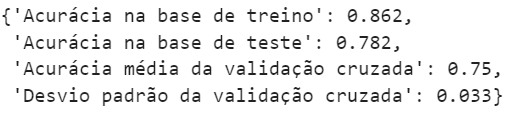    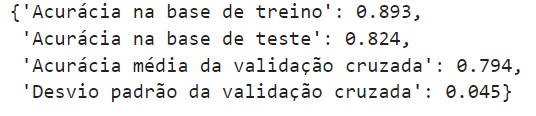


Comparando a imagem acima que traz os resultados obtidos, repete-se o mesmo que nos exemplos anteriores. 

O método não padronizado acaba tendo um desvio padrão maior da validação cruzada, entretanto, esse valor ainda não chega a ser alto e todas as demais métricas se mostram melhores, **levando então uma vantagem sobre os dados padronizados.**

_Mas vale lembrar que os dados dessa base já eram normalizados, talvez em um contexto em que não fossem, não teriamos o mesmo resultado._